In [ ]:
install.packages("MASS")
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




# Dataframe diagonal

In [ ]:
library(MASS)
set.seed(123)

gen_diag_df <- function(n = 20000, d=2, C=1) {
  mean_vector1 <- rep(1,d)
  mean_vector2 <- rep(-1,d)

  cov_matrix <- diag((C * sqrt(d))^2, d)

  samples1 <- mvrnorm(n = n/2, mu = mean_vector1, Sigma = cov_matrix)
  samples2 <- mvrnorm(n = n/2, mu = mean_vector2, Sigma = cov_matrix)

  df_samples1 <- as.data.frame(samples1)
  df_samples1$class <- 1

  df_samples2 <- as.data.frame(samples2)
  df_samples2$class <- 0

  df <- rbind(df_samples1, df_samples2)

  return(df)
}

## Plot

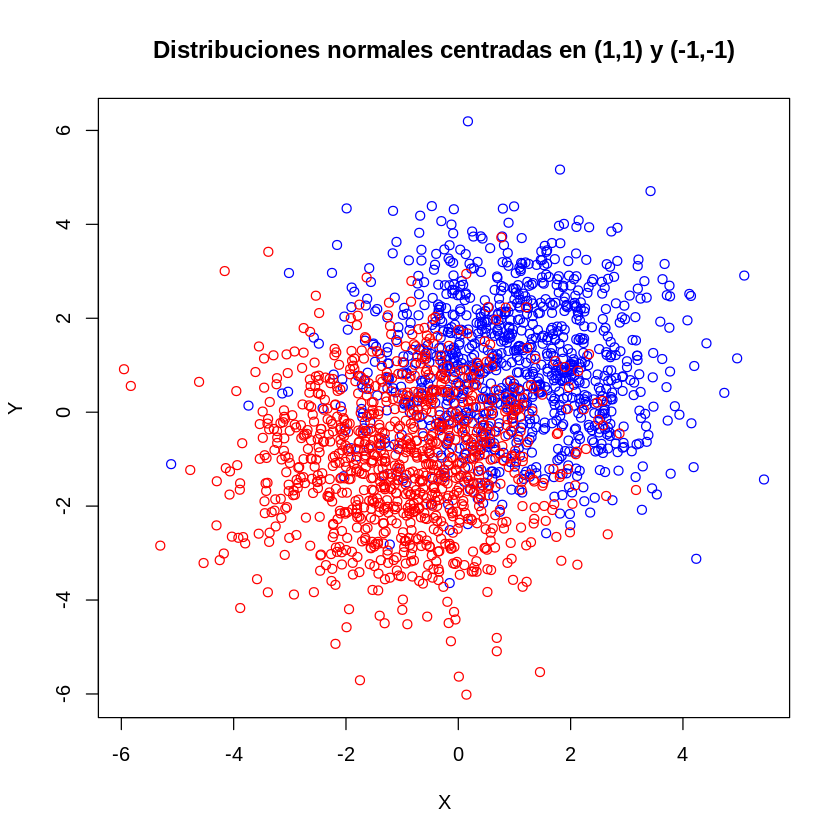

In [ ]:
df <- gen_diag_df(n=2000)

plot(df[,1], df[,2], col = ifelse(df$class == 1, "blue", "red"), xlab="X", ylab="Y",
     main="Distribuciones normales centradas en (1,1) y (-1,-1)")

# Dataframe espiral

In [ ]:
set.seed(123)

gen_espiral_df <- function(n = 20000) {
  theta <- runif(n, 0, 2*pi)
  r <- sqrt(runif(n, 0, 1))

  x <- r * cos(theta)
  y <- r * sin(theta)

  loop0 <- r >= (theta-2*pi) / (4 * pi) & r <= ((theta-2*pi) + pi) / (4 * pi)
  loop1 <- r >= theta / (4 * pi) & r <= (theta + pi) / (4 * pi)
  loop2 <- r >= (theta+2*pi) / (4 * pi) & r <= ((theta+ 2*pi) + pi) / (4 * pi)

  class <- ifelse(loop0 | loop1 | loop2, 1, 0)

  df <- data.frame(x = x, y = y, class = class)

  return(df)
}

## Plot

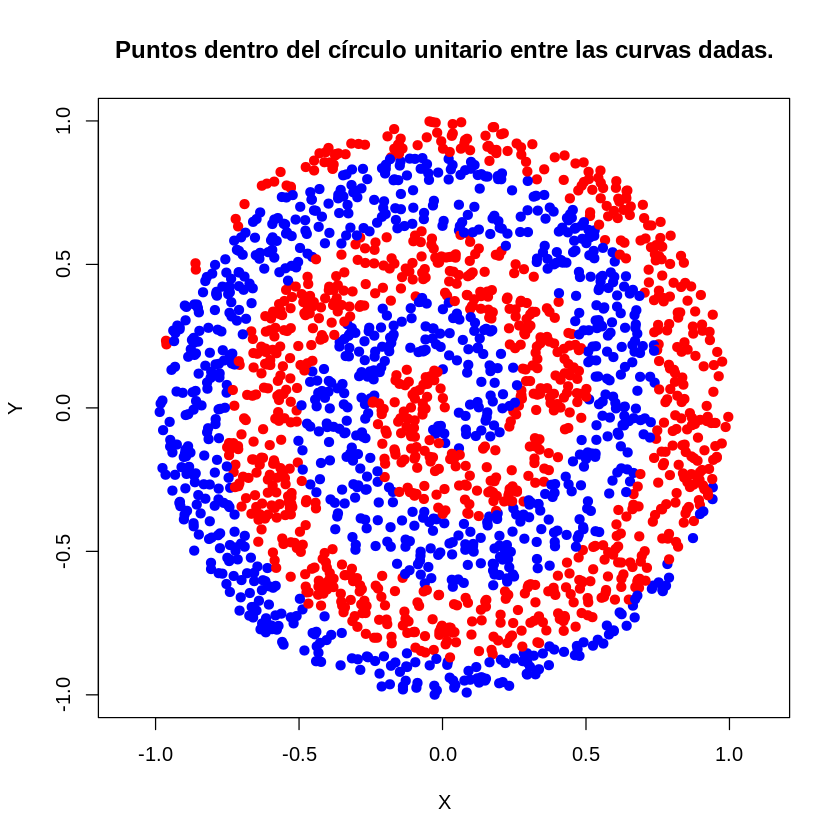

In [ ]:
df <- gen_espiral_df(n = 2000)

plot(df$x, df$y, col = ifelse(df$class == 1, "blue", "red"),
     pch = 19, xlab = "X", ylab = "Y",
     main = "Puntos dentro del círculo unitario entre las curvas dadas.", asp = 1)

# Data partitions

Se generan las particiones de los datos. Un conjunto de train de 300 puntos y uno de test de 10000 puntos.

In [ ]:
library(caret)
set.seed(123)

partition_data <- function(df, n_train, n_test) {
  df$class <- factor(df$class)

  head(df, n_train + n_test)

  train_indices <- createDataPartition(df$class, p = n_train/nrow(df), list = FALSE)

  train_set <- df[train_indices, ]
  test_set <- df[-train_indices, ]

  return (list(train = train_set, test = test_set))
}

diag_df <- gen_diag_df(n=10300)
espiral_df <- gen_espiral_df(n=10300)

partition_diag <- partition_data(diag_df, 300, 10000)
partition_espiral <- partition_data(espiral_df, 300, 10000)

train_diag <- partition_diag$train
test_diag <- partition_diag$test

train_espiral <- partition_espiral$train
test_espiral <- partition_espiral$test

# Árbol de decisión

Se ajusta un clasificador de árbol, utilizando el conjunto de train para construir el árbol y el de test para medir la performance del modelo.

In [ ]:
library(rpart)
set.seed(123)

arbol_decision <- function(train_set, test_set, df_name) {
  tree_model <- rpart(class ~ ., data = train_set, method = "class")

  predictions <- predict(tree_model, newdata = test_set[,-ncol(test_set)], type = "class")

  tree_error <- mean(predictions != test_set$class)
  print(paste("Error en test (Árbol de decisión):", tree_error, ". Para el dataframe:", df_name))
}

arbol_decision(train_diag, test_diag, "diagonal")

arbol_decision(train_espiral, test_espiral, "espiral")

[1] "Error en test (Árbol de decisión): 0.2012 . Para el dataframe: diagonal"
[1] "Error en test (Árbol de decisión): 0.22022202220222 . Para el dataframe: espiral"


# K-vecinos

Se ajusta un modelo de k-vecinos usando un k fijo de 10 vecinos.

In [ ]:
library(class)
set.seed(123)

k_vecinos <- function(train_set, test_set, df_name) {
  k <- 10
  knn_model <- knn(train = train_set[,-ncol(train_set)], test = test_set[,-ncol(test_set)],
                  cl = train_set$class, k = k)

  knn_error <- mean(knn_model != test_set$class)
  print(paste("Error en test (K-Vecinos):", knn_error, ". Para el dataframe:", df_name))
}


k_vecinos(train_diag, test_diag, "diagonal")

k_vecinos(train_espiral, test_espiral, "espiral")

[1] "Error en test (K-Vecinos): 0.178 . Para el dataframe: diagonal"
[1] "Error en test (K-Vecinos): 0.186318631863186 . Para el dataframe: espiral"


# Árbol de decisión (5-fold CV)

Se utiliza solamente el conjunto de train para ajustar un modelo de árbol de decisión. Se aplica también cross validation con 5 folds.

In [ ]:
library(caret)
set.seed(123)

k_fold_decision_tree <- function(train_set) {
  control <- trainControl(method = "cv", number = 5)

  tree_model <- train(class ~ ., data = train_set, method = "rpart", trControl = control)
  print(tree_model$results)
}

print("Usando 5-fold con árbol de decisión para el dataset diagonal.")
k_fold_decision_tree(train_diag)

print("Usando 5-fold con árbol de decisión para el dataset espiral.")
k_fold_decision_tree(train_espiral)

[1] "Usando 5-fold con árbol de decisión para el dataset diagonal."
          cp  Accuracy     Kappa AccuracySD    KappaSD
1 0.01666667 0.7833333 0.5666667 0.04249183 0.08498366
2 0.10666667 0.7733333 0.5466667 0.06191392 0.12382784
3 0.52000000 0.5866667 0.1733333 0.12099128 0.24198255
[1] "Usando 5-fold con árbol de decisión para el dataset espiral."
          cp  Accuracy     Kappa AccuracySD    KappaSD
1 0.07333333 0.5815301 0.1657345 0.04116200 0.07918853
2 0.08000000 0.5815301 0.1657345 0.04116200 0.07918853
3 0.12666667 0.5781967 0.1590678 0.04638432 0.09024509


En los resultados se puede ver que el accuracy es similar al obtenido anteriormente pero esta vez con muchos menos puntos. También ajusta el parámetro 'cp' para controlar el tamaño del árbol con pruning.
Para el dataset espiral no hubo resultados tan buenos como cuando se usaron más puntos.

# K-vecinos (5-fold CV)

In [ ]:
library(caret)
set.seed(123)

k_fold_knn <- function(train_set) {
  control <- trainControl(method = "cv", number = 5)

  knn_model <- train(class ~ ., data = train_set, method = "knn", trControl = control)

  print(knn_model$results)
}

print("Usando 5-fold con árbol de decisión para el dataset diagonal.")
k_fold_knn(train_diag)

print("Usando 5-fold con árbol de decisión para el dataset espiral.")
k_fold_knn(train_espiral)


[1] "Usando 5-fold con árbol de decisión para el dataset diagonal."
  k  Accuracy     Kappa AccuracySD    KappaSD
1 5 0.8166667 0.6333333 0.04714045 0.09428090
2 7 0.8233333 0.6466667 0.04801620 0.09603240
3 9 0.8166667 0.6333333 0.04082483 0.08164966
[1] "Usando 5-fold con árbol de decisión para el dataset espiral."
  k  Accuracy     Kappa AccuracySD    KappaSD
1 5 0.8137158 0.6275915 0.05513523 0.11052989
2 7 0.8138251 0.6277927 0.03277299 0.06575625
3 9 0.7805464 0.5613562 0.04991011 0.10018737


En este caso, se obtienen resultados similares al método "directo" para ambos datasets. En el proceso de CV también se ajusta el parámetro k.